# Basics of mobile robotics Project

**Authors:**\
Badil Mujovi (274632)\
Aubin Mercier (316260)\
Mehmet Furkan Dogan (370234)\
Andrea Grillo (371099)

# Introduction

This project aims to combine vision, global and local navigation, and filtering to maneuver a Thymio robot in a predetermined environment.

Our environment consist of ...

Our implementation includes the following features:
- a
- b

# 1. Computer Vision

# 2. Path Planning

# 3. Filtering

# 4. Local Navigation

# 5. Motion control

# Complete code

# Conclusion

# SCAFFOLDING

In [21]:
#  - - - CONSTANT DEFINITION - - -

USE_THYMIO = True

# sampling time
DT = .1


#  - - - IMPORTS - - - 
import tdmclient.notebook
import time
import local_navigation
from vision_thymio import *


if USE_THYMIO:
    await tdmclient.notebook.start()


print("Import executed successfully")

NodeLockError: Node lock error (current status: busy)

In [14]:
# - - - RELOADING OF IMPORTED MODULES - - -
import importlib
importlib.reload(local_navigation)
#importlib.reload(vision_thymio)

<module 'local_navigation' from 'c:\\Users\\andrea\\Dropbox (Politecnico Di Torino Studenti)\\Tirocinio Andrea Grillo\\08 FIRMWARE\\sensoriPaquitop\\mobile-robotics-project\\local_navigation.py'>

In [2]:
# FUNCTION FOR THYMIO INTERACTION DEFINITION

@tdmclient.notebook.sync_var
def motor_go(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal

@tdmclient.notebook.sync_var
def odometry():
    global motor_left_speed, motor_right_speed
    return (motor_left_speed, motor_right_speed)

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [3]:
motor_go(50,50)
time.sleep(0.5)
motor_stop()

In [4]:
# create object
vis = Vision_Thymio()
time.sleep(1) #make sure that everything is loaded

# init of the perspective and scaling of the image
vis.getPerspectiveAndScaling()

# get obstacles on the map
img = vis.getCorrectedImage()
staticObstacleList = vis.getVisibilityGraph(img)



init object


In [41]:
vis.stopVideoCapture()

In [33]:
foundGoal = foundThymio = False
goalPos = []
thymioPos = []

# try ten times to get thymio and goal position on the map, if not print error and exit
for i in range(10):
    img = vis.getCorrectedImage()
    ids,corners = vis.detectArucoMarkers(img)

    if not foundGoal:
        foundGoal, goalPos = vis.getGoalPosition(ids, corners)
    if not foundThymio:
        foundThymio, thymioPos = vis.getThymioPos(ids,corners) 

    if foundGoal and foundThymio:
        break
    
    time.sleep(0.1)

if not (foundGoal and foundThymio):
    print("ERROR - cannot found goal or thymio")

print(f"found thymio and goal at iteration {i}")
print(f"position of the thymio: {thymioPos}")
print(f"position of the goal: {goalPos}")


path = vis.getOptimalPath(thymioPos[0], staticObstacleList, goalPos)
path = list(map(tuple, path.reshape((path.shape[0], 2))))
print(path)

local_nav = local_navigation.Local_Navigation(path)


found thymio and goal at iteration 0
position of the thymio: (array([33.90625, 22.8625 ]), -0.6993169987780069)
position of the goal: [ 5.92875 23.44375]
[(33.90625, 22.8625), (5.92875, 23.44375)]
init local nav


In [34]:

for i in range(200):
    img = vis.getCorrectedImage()
    ids,corners = vis.detectArucoMarkers(img)
    foundThymio, thymioPos = vis.getThymioPos(ids,corners) 
    if not foundThymio:
        print("LOST FRAME - - - - - - - - - - - - - - - - - - - - - - - ")
        continue
    x,y = thymioPos[0][0], thymioPos[0][1]
    v,w = local_nav.path_follow((x,y,thymioPos[1]))

    wl,wr= local_nav.differential_steering(v,w)
    
    print(f"linear,angular velocities {(v,w)}") 
    print(f"differential steering {(wl,wr)}") 
    
    motor_go(wl,wr)

    if abs(wl) > 4000 or abs(wr) > 4000:
        print(f"SATURATED")
        
    if (v,w) == (-1,-1):
        print("FINISHED")
        break


    time.sleep(DT)
motor_stop()

My pose is 33.90625 22.8625 -40.01758040962419
My objective is (33.90625, 22.8625)
Distance is 0.0
the angle i have to follow 0.0
reached objective number 0
My pose is 33.90625 22.8625 -40.01758040962419
My objective is (5.92875, 23.44375)
Distance is 27.983537264121917
the angle i have to follow 178.80981568861637
DELTA ANGLE DEG: 141.17260390175943
linear,angular velocities (5596.707452824384, 70.43028730656425)
differential steering (-159, 579)
My pose is 33.8675 22.8625 -40.333141628561
My objective is (5.92875, 23.44375)
Distance is 27.944795635770895
the angle i have to follow 178.80816542335927
DELTA ANGLE DEG: 140.8586929480797
linear,angular velocities (5588.9591271541785, 70.43069987287852)
differential steering (-160, 579)
My pose is 33.8675 22.8625 -40.28524548129506
My objective is (5.92875, 23.44375)
Distance is 27.944795635770895
the angle i have to follow 178.80816542335927
DELTA ANGLE DEG: 140.90658909534568
linear,angular velocities (5588.9591271541785, 70.43069987287

In [13]:
motor_stop()

In [ ]:
'''last_time = time.time()


state = 1
' ''
     States of the global FSM (finite state machine)
     
     1 -> computer vision and global path planning
     2 -> path following
     3 -> obstacle avoidance
     4 -> target reached
' ''
print(" - - - START MAIN CODE - - -")
#filtering

while True:
    # we have to estimate our pose regardless of our state
    # ToDo vision_position = vision.get_position()
    # ToDo motion data
    # ToDo pose_estimation = filtering (vision_position,data)
    # 
    pose_estimation = (10,15,0.23) # tuple (x,y,theta)
    
    
    if state == 1:
        print("MAIN FSM -> computer vision")
        # ToDo get nodes and edges from computer vision module
        
        nodes = [(1,2),(3,4),(5,6),(10,11)]

        global_nav = Global_Navigation(nodes)

        global_nav.add_edge((1,2),(3,4))
        global_nav.add_edge((1,2),(5,6))
        global_nav.add_edge((3,4),(10,11))
        global_nav.add_edge((10,11),(5,6))


        start_node = (1,2)
        target_node= (10,11)

        
        # next state -> path planning
        state = 2
        
    elif state == 2:
        print("MAIN FSM -> path planning")
        path = global_nav.path_planning(start_node,target_node)
        local_nav = Local_Navigation(path) 

        # next state -> path following
        state = 3
    elif state == 3:
        print("MAIN FSM -> path following")
        
        
        #if obstacle_present():
        #    state = 4
        #    continue
        state = 5
        
    elif state == 4:
        print("MAIN FSM -> obstacle avoidance")
        
        #if not obstacle_present():
        #    state = 3
        #    continue
        
        
        
    elif state == 5:
        print("MAIN FSM -> terminated")
        break
    
    # wait DT time - DT includes calculation time
    while True:
        
        act_time = time.time()
        if act_time - last_time >= DT:
            last_time = act_time
            break
            

print(" - - -    FINISHED     - - - ")
'''
print("skipped main code")

In [34]:
motor_go(40,40)

In [4]:
motor_stop()

In [ ]:
print_prox_value()

[0, 0, 0, 0, 0, 0, 0]

IN
eps: 0.1
iteration number 0
My pose is (0, 0, 0.7853981633974483)
My objective is (0, 0)
Distance is 0.0
reached objective number 0
My pose is (0, 0, 0.7853981633974483)
My objective is (1, 0)
Distance is 1.0
differential steering (469, -468)
iteration number 1
My pose is (0.0004419417382415922, 0.0004419417382415922, 0.7785259294677206)
My objective is (1, 0)
Distance is 0.999558155961181
differential steering (466, -464)
iteration number 2
My pose is (0.000886713537065729, 0.0008806420147124773, 0.7717096825494878)
My objective is (1, 0)
Distance is 0.9991136745721797
differential steering (462, -460)
iteration number 3
My pose is (0.001334266164575772, 0.0013161067213566932, 0.764948959483211)
My objective is (1, 0)
Distance is 0.9986666010606084
differential steering (458, -456)
iteration number 4
My pose is (0.0017845510185394895, 0.0017483422206880875, 0.7582433011095338)
My objective is (1, 0)
Distance is 0.9982169800628415
differential steering (454, -453)
iteration number 5

KeyboardInterrupt: 

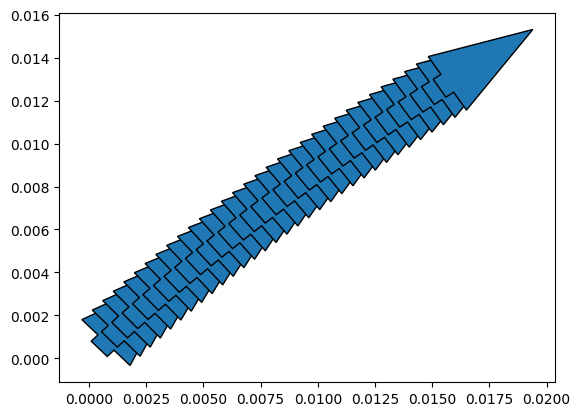

In [ ]:
import matplotlib.pyplot as plt 
import math 
nodes = [(0,0),(1,0),(3,10),(5,5),(10,2),(12,7)]


local_nav = local_navigation.Local_Navigation(nodes)
last_time = time.time()

#pose = []
#pose.append((0,0,45* math.pi / 180))
x = [0]
y = [0]
theta = 45 * math.pi / 180
for i in range(20000):
    
    print(f"iteration number {i}")
    v,w = local_nav.path_follow((x[-1],y[-1],theta))

    wl,wr= local_nav.differential_steering(v,w)
    print(f"differential steering {(wl,wr)}") 
    motor_go(wl,wr)
    if abs(wl) > 500 or abs(wr) > 500:
        print(f"SATURATED")
        break
    if (v,w) == (-1,-1):
        print("FINISHED")
        break
    #pose.append(   (pose[-1][0] + v * math.cos(pose[-1][2])/400, pose[-1][1] + v * math.sin(pose[-1][2])/400, pose[-1][2] + w/400) )
    x.append(x[-1] + v *  math.cos(theta)/400)
    y.append( y[-1] + v * math.sin(theta)/400)
    theta = theta + w/400
    
    
    plt.arrow(x[-1],y[-1],v*math.cos(theta)/600,v*math.sin(theta)/600)
    while True:

        act_time = time.time()
        if act_time - last_time >= DT:
            last_time = act_time
            break
            

for i in range(len(nodes)):
    plt.scatter(nodes[i][0],nodes[i][1])
    
plt.show()